In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color

# Question 1 : Huffman Binary Tree (40 points)
Huffman coding is a lossless image compression technique. In this problem, we will
understand the Huffman coding algorithm better, but will not be required to implement it.
PS; you will not be required to generate the compressed image from the original image.

a) (5 points) Read the image heart.jpg, convert the image to grayscale with each
pixel ranging between 0 and 15 (only 4 bits to represent each pixel), and display
the histogram of the image.

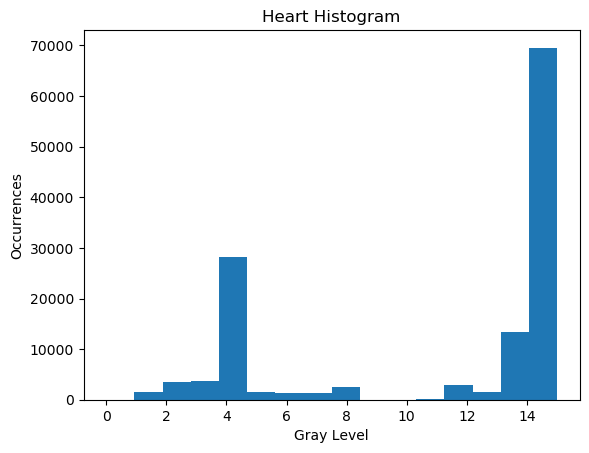

In [2]:
def histogram(img, max_val=256):
    histogram = np.zeros(16)
    rows = img.shape[0]
    cols = img.shape[1]
    for i in range(rows):
        for j in range(cols):
            histogram[img[i][j]] += 1
    return histogram.astype(int)

heart = mpimg.imread('images/q1_huffman.jpg')
heart = heart[:, :, :3]
heart = np.uint8(color.rgb2gray(heart) * 15)

hist = histogram(heart, max_val=16)
plt.hist(list(range(0, 16)), weights=hist, bins=16)
plt.title('Heart Histogram')
plt.xlabel('Gray Level')
plt.ylabel('Occurrences')
plt.show()

b) (15 points) Write a python/matlab function to generate the Huffman tree. The
function should take the input parameter as an array of size 16 which contains
the corresponding number of occurrences for each pixel value. The function
should then calculate the probabilities for each pixel value, and then generate the
Huffman tree as described in the module slides. Display the Huffman tree for
heart.jpg with proper formatting by generating the input array of size 16 for the
image and passing through the function.

In [3]:
from ppbtree import print_tree

class huffman_node:
    def __init__(self, value=None, code=None, probability=0, left=None, right=None):
        if value is not None:
            self.name = [round(probability, 5), value]
        else:
            self.name = round(probability, 5)
        self.value = value
        self.code = code
        self.probability = probability
        self.left = left
        self.right = right
        
    def set_code(self, current=''):
        if self.value is not None:
            self.code = current
            self.name.append(current)
        else:
            if self.left is not None:
                self.left.set_code(current + '0')
            if self.right is not None:
                self.right.set_code(current + '1')
    
    def get_code(self, current={}):
        if self.value is not None:
            current[self.value] = self.code
        else:
            if self.left is not None:
                self.left.get_code(current)
            if self.right is not None:
                self.right.get_code(current)
                
        return current
            

def huffman_tree(histogram=[]):
    nodes = [huffman_node(value=level, probability=occurrences / np.sum(histogram)) 
              for level, occurrences in enumerate(histogram) if occurrences != 0]
    
    for i in range(len(nodes) - 1):
        nodes.sort(key=lambda x: x.probability)
        right = nodes.pop(0)
        left = nodes.pop(0)
        nodes.append(huffman_node(probability=left.probability+right.probability, left=left, right=right))
    
    nodes[0].set_code()
    return nodes[0]        

root = huffman_tree(hist)
print_tree(root, nameattr='name', left_child='left', right_child='right')


    ┌[0.5314, 15, '0']
 1.0┤
    |                                      ┌[0.02723, 2, '100000']
    |                              ┌0.04943┤
    |                              |       |      ┌[0.01118, 1, '1000010']
    |                              |       └0.0222┤
    |                              |              └[0.01102, 13, '1000011']
    |                      ┌0.09134┤
    |                      |       |       ┌[0.02212, 12, '100010']
    |                      |       └0.04191┤
    |                      |               └[0.01979, 8, '100011']
    |              ┌0.15073┤
    |              |       |                               ┌[0.00957, 6, '10010000']
    |              |       |                       ┌0.01002┤
    |              |       |                       |       |       ┌[0.00041, 11, '100100010']
    |              |       |                       |       └0.00044┤
    |              |       |                       |               |     ┌[2e-05, 10, '1001000110']


c) (10 points) Write a python/matlab function which extends/uses the previous
function, and additionally calculates the codeword for each pixel value from 0 to 15. 
The function should take the input parameter as an array of size 16 with the
corresponding number of occurrences for each pixel value. Display the codeword
generated for each pixel value in heart.jpg by generating the input array of size
16 for the image and passing through the function.

In [4]:
def get_codes(histogram):
    root = huffman_tree(histogram)
    return root.get_code()

print(sorted(get_codes(hist).items()))


[(1, '1000010'), (2, '100000'), (3, '10011'), (4, '11'), (5, '100101'), (6, '10010000'), (7, '1001001'), (8, '100011'), (9, '1001000111'), (10, '1001000110'), (11, '100100010'), (12, '100010'), (13, '1000011'), (14, '101'), (15, '0')]


d) (10 points) Write a python/matlab function which extends/uses the previous
function, and additionally calculates the new BPP and the compression ratio after
applying Huffman coding. The function should take the input parameter as an
array of size 16 with the corresponding number of occurrences for each pixel
value, and the output of the function should be the new BPP and the
compression ratio. Report the BPP and compression ratio achieved for heart.jpg
by generating the input array of size 16 for the image and passing through the
function.

In [5]:
def compute_ratios(histogram):
    probabilities = histogram / np.sum(histogram)
    codes = get_codes(histogram)
    orig_bits = math.log2(len(histogram))
    code_bits = sum(len(codes[key]) * probabilities[key] for key in codes.keys())
    ratio = orig_bits / code_bits
    return code_bits, ratio

bpp, compression = compute_ratios(hist)
print(f'BPP: {bpp}')
print(f'CR: ({compression}:1)')

BPP: 2.1985714285714284
CR: (1.819363222871995:1)


# Question 2 : Reference Image Quality Assessment (30 points)
In this problem, we will be using MSE and PSNR to quantify the quality of different
images with respect to an original image.

a) (5 points) Convert the golden.jpg image to grayscale, and apply FSCS on the
resulting grayscale image. Display the original grayscale image and the image
after FSCS side-by-side with appropriate labels.

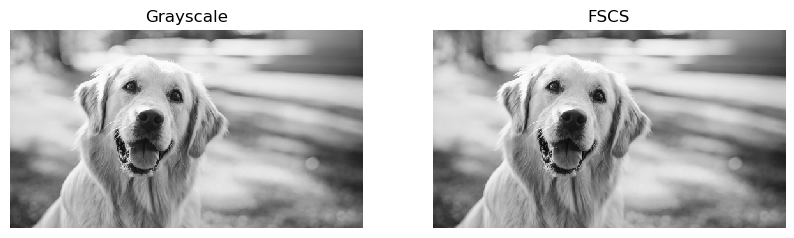

In [6]:
def func_fscs(img):
    A = np.amin(img)
    B = np.amax(img)
    P = (256 - 1) / (B - A)
    L = -A * (256 - 1) / (B - A)
    rows = img.shape[0]
    cols = img.shape[1]
    fscs_img = img.copy()
    for i in range(rows):
        for j in range(cols):
            fscs_img[i][j] = P * fscs_img[i][j] + L
    return fscs_img

golden = mpimg.imread('images/q2_qualityAssessment.jpg')
golden = color.rgb2gray(golden) * 255
fscs = func_fscs(golden)

fig = plt.figure(figsize=(10, 3.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Grayscale')
ax2.title.set_text('FSCS')
ax1.imshow(golden, cmap='gray', vmin=0, vmax=255)
ax2.imshow(fscs, cmap='gray', vmin=0, vmax=255)
plt.show()


b) (5 points) Convert the golden.jpg image to grayscale. Randomly choose 20% of
the pixels and change their intensity to 0. Display the original grayscale image
and the resulting grayscale image side-by-side with appropriate labels.

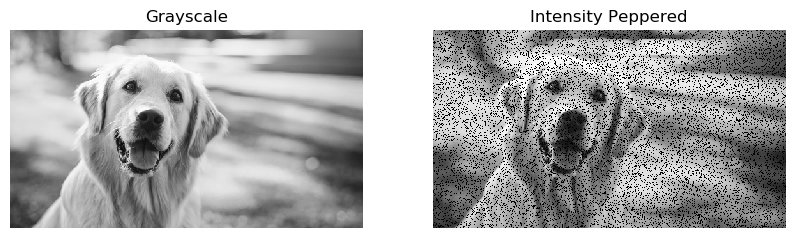

In [7]:
def pepper(img, fraction=1/5):
    upper_bound = (1 / fraction) + 1
    pepper = np.random.randint(0, upper_bound, img.shape).clip(0, 1)
    return np.multiply(img, pepper)

peppered = pepper(golden)
fig = plt.figure(figsize=(10, 3.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Grayscale')
ax2.title.set_text('Intensity Peppered')
ax1.imshow(golden, cmap='gray', vmin=0, vmax=255)
ax2.imshow(peppered, cmap='gray', vmin=0, vmax=255)
plt.show()

c) (5 points) Convert the golden.jpg image to grayscale. Apply the gamma
correction algorithm on this grayscale image for a gamma value of 0.95. Display
the original grayscale image and the resulting gamma corrected grayscale image
side-by-side with appropriate labels.

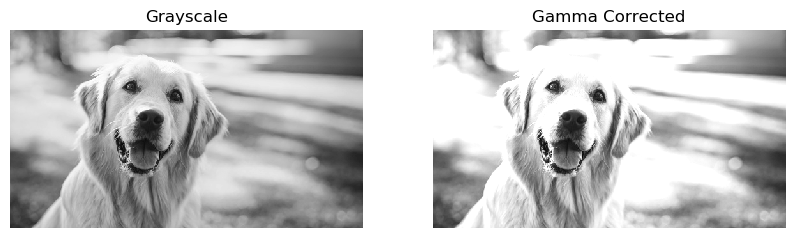

In [8]:
def func_gamma(img, gamma):
    return np.power(img, 1 / gamma).astype(int)

gamma = func_gamma(golden, 0.95)
fig = plt.figure(figsize=(10, 3.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Grayscale')
ax2.title.set_text('Gamma Corrected')
ax1.imshow(golden, cmap='gray', vmin=0, vmax=255)
ax2.imshow(gamma, cmap='gray', vmin=0, vmax=255)
plt.show()

d) (10 points) Write a python/matlab function to take in two grayscale images as
input, and give the MSE and PSNR of the second image with reference to the
first image (original image) as the output.

In [9]:
def metrics(img1, img2):
    mse = (np.square(img1 - img2)).mean()
    psnr = 10 * math.log10((255 ** 2) / math.sqrt(mse))
    return mse, psnr

e) (5 points) Run the function written in the previous parts, and report the MSE and
PSNR for the images generated in parts a), b) and c) with reference to the
original grayscale golden.jpg image. Report these values in a table with clear
labels. Comment a few lines on the MSE values observed, the similarities and
differences between the MSE values of the different images, and whether MSE
captures the quality of an image effectively.

In [10]:
img_names = ['FSCS Image', 'Intensity Peppered', 'Gamma Corrected']
imgs = [fscs, peppered, gamma]
m = [metrics(img, golden) for img in imgs]

print ("{:<20} {:<20} {:<20}".format('Image','MSE','PSNR'))
for i, (mse, psnr) in enumerate(m):
    print ("{:<20} {:<20} {:<20}".format(img_names[i], mse, psnr))

Image                MSE                  PSNR                
FSCS Image           3.0441498845780717   45.71347344893111   
Intensity Peppered   4858.264043159266    29.698398035161446  
Gamma Corrected      2831.2949263521195   30.870878055184605  


**Answer:** MSE Error is very low for the FSCS image and very high for both the gamma corrected and peppered images. MSE does not capture the quality of an image effectively in certain situations. The quality difference between the gamma corrected and FSCS image isn't as huge as it makes it seem; its value is closer to the peppered image, which looks much worse, than the FSCS image)

# Question 3 : Hough Transform (30 points)
In this problem, we will be utilizing the hough transform to detect lines in the lines.jpg
image.

a) (10 marks) Consider Question 3 of HW2. This question is a continuation of that
question. Refer to HW2 in Canvas → Files tab to access the Question 3 of HW2.
If you have not completed Q3 in HW2, complete it now and display the four DoG
filtered images of lines.jpg ( instead of flowers.jpg asked in “HW2 Q3 part c” ) in a
2x2 grid with the appropriate labels.

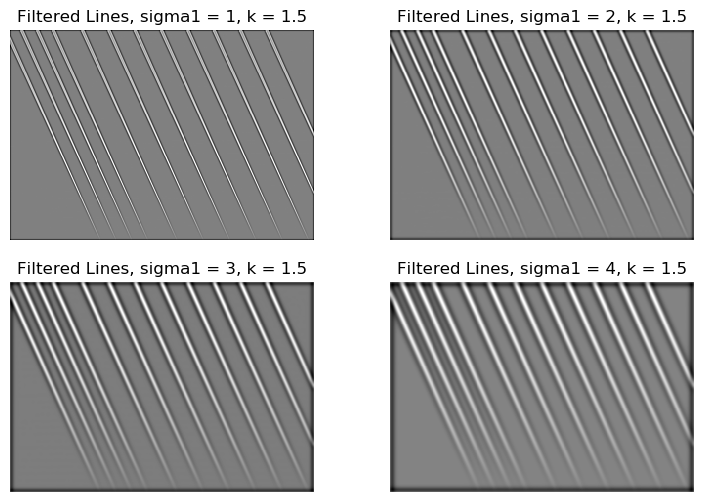

In [11]:
def mylinearfilter(img, h):
    rows = img.shape[0] + h.shape[0] - 1
    cols = img.shape[1] + h.shape[1] - 1
    dft_img = np.fft.fft2(img, (rows, cols))
    dft_h = np.fft.fft2(h, (rows, cols))
    dft = np.multiply(dft_img, dft_h)
    unpad_rows = int((rows - img.shape[0]) / 2)
    unpad_cols = int((cols - img.shape[1]) / 2)
    return np.fft.ifft2(dft)[unpad_rows:-unpad_rows, unpad_cols:-unpad_cols]

def myDoG(DoGsize, sigma1, k):
    sigma2 = k * sigma1
    square_size = min(DoGsize)
    kernel1 = cv2.getGaussianKernel(square_size, sigma1)
    kernel1 = kernel1 * np.transpose(kernel1)
    kernel2 = cv2.getGaussianKernel(square_size, sigma2)
    kernel2 = kernel2 * np.transpose(kernel2)
    kernel = kernel2 - kernel1
    rows_border = max(0, int((DoGsize[0] - square_size) / 2))
    cols_border = max(0, int((DoGsize[1] - square_size) / 2))
    return cv2.copyMakeBorder(kernel, rows_border, rows_border, cols_border, cols_border, cv2.BORDER_CONSTANT, None, value=0)

lines = mpimg.imread('images/q3_hough.jpg')
lines = color.rgb2gray(lines) * 255
# trim an edge
g_flowers = lines[:, 1:]

filters = [myDoG(lines.shape, sigma1, 1.5) for sigma1 in range(1, 5)]
filtered_imgs = [mylinearfilter(lines, filters[i]) for i in range(len(filters))]

fig = plt.figure(figsize=(9, 6))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.axis('off') 
    ax.title.set_text('Filtered Lines, sigma1 = ' + str(i+1) + ', k = 1.5')
    ax.imshow(np.real(filtered_imgs[i]), cmap='gray')
plt.show()

b) (10 marks) One useful application of DoG filtering is edge detection. After DoG
filtering, zero-crossings occur near the center of edges, where the DoG goes
from positive to negative or from negative to positive between neighboring pixels.
On the four filtered images of lines.jpg, find horizontal and vertical zero-crossings
to generate the corresponding edge maps. In the edge maps, set the value of
pixels corresponding to zero-crossings to 1 and the rest to 0. Display the four
edge maps and write a few lines on your observations.

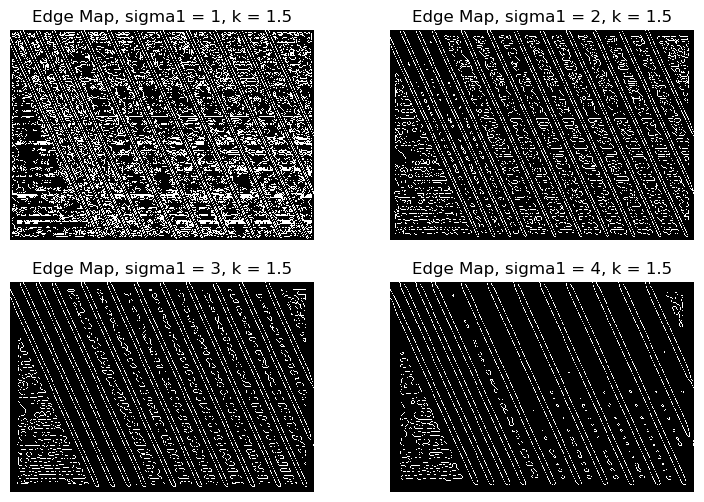

In [12]:
def zero_crossings(img):
    edge_map = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (i < img.shape[0] - 1):
                edge_map[i, j] = 1 if np.sign(img[i, j]) != np.sign(img[i+1, j]) else edge_map[i, j]
            if (j < img.shape[1] - 1):
                edge_map[i, j] = 1 if np.sign(img[i, j]) != np.sign(img[i, j+1]) else edge_map[i, j]
    return edge_map

edge_maps = [zero_crossings(np.real(img)) for img in filtered_imgs]
fig = plt.figure(figsize=(9, 6))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.axis('off') 
    ax.title.set_text('Edge Map, sigma1 = ' + str(i+1) + ', k = 1.5')
    ax.imshow(edge_maps[i], cmap='gray')
plt.show()

**Answer:** We see that the higher value of sigma we use the less noise shows up in the edge map. This makes sense since we are increasing the size of the band while reducing its extreme point, so less noise is accentuated in the last edge map.

c) (10 points) In this part, we will be using the hough transform to detect lines in the
edge map generated in the previous question. Take any one of the four edge
maps generated. Write a function in python/matlab which takes in the input
parameter as the edge map image, and gives the output as a grayscale image
with only the detected lines. In this function, you will use an internal array of “rho
x theta” size, and use this as a hough accumulator and increment an index as
you find a line. Then, use a suitable threshold, and every index in the array
greater than this threshold should be considered a line. Then with the (rho, theta)
pairs found above the threshold, generate a grayscale image with the lines
generated using these (rho, theta) pairs. Run one of the edge maps of lines.jpg
through this function, and display both the original lines.jpg image and the
generated grayscale “line detection” image side-by-side with the appropriate
labels

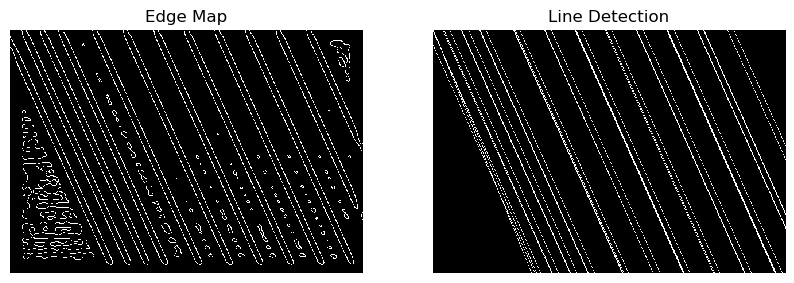

In [13]:
def hough_transform(edge_map, threshold=100, num_lines=0):
    # if num_lines set to 0, then it is ignored
    
    width, height = edge_map.shape
    diagonal = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diagonal, diagonal, diagonal * 2)
    thetas = np.deg2rad(np.arange(-90, 90, 1))
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    A = np.zeros((2 * diagonal, len(thetas)), dtype=np.uint8)
    
    xs, ys = np.nonzero(edge_map)
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        for theta_idx in range(len(thetas)):
            rho = diagonal + int(x * cos_t[theta_idx] + y * sin_t[theta_idx])
            A[rho, theta_idx] += 1   
            
    indices =  np.argpartition(A.flatten(), -2)[-num_lines:]
    indices = np.vstack(np.unravel_index(indices, A.shape)).T  
            
    lines = np.transpose(np.zeros_like(edge_map).astype(np.uint8))
    lines = cv2.cvtColor(lines, cv2.COLOR_GRAY2BGR)
    for i in range(len(indices)):
        if (A[indices[i][0], indices[i][1]] > threshold):
            rho = rhos[indices[i][0]]
            a = cos_t[indices[i][1]]
            b = sin_t[indices[i][1]]
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 - b * 1000)
            y1 = int(y0 + a * 1000)
            x2 = int(x0 + b * 1000)
            y2 = int(y0 - a * 1000)
            # print(rho, a, b, A[rho, theta_idx], (x1, y1), '-->', (x2, y2))
            cv2.line(lines, (x1, y1), (x2, y2), (0, 255, 0), 1)
    return np.transpose(cv2.cvtColor(lines, cv2.COLOR_BGR2GRAY))

lines = hough_transform(edge_maps[3], threshold=125)
fig = plt.figure(figsize=(10, 3.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Edge Map')
ax2.title.set_text('Line Detection')
ax1.imshow(edge_maps[3], cmap='gray')
ax2.imshow(lines, cmap='gray')
plt.show()
    